In [65]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from q_alchemy.qiskit import QAlchemyInitialize
from qiskit.quantum_info import Statevector, partial_trace
import os
from qiskit import transpile
from data import load_01
import autograd.numpy as anp
from scipy.optimize import minimize
from sklearn.metrics import log_loss

os.environ["Q_ALCHEMY_API_KEY"] = "JnvkpMCsyr4nB9nHcwa6CbxqhtZXyF1b"

algorithm_globals.random_seed = 12345

## SU4 convolutional layer

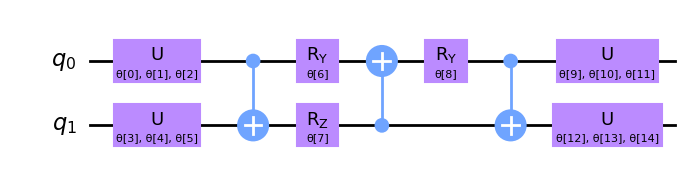

In [2]:
# We now define a convolutional layer with SU4 gate
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.u(params[0], params[1], params[2], 0)
    target.u(params[3], params[4], params[5], 1)
    target.cx(0, 1)
    target.ry(params[6], 0)
    target.rz(params[7], 1)
    target.cx(1, 0)
    target.ry(params[8], 0)
    target.cx(0, 1)
    target.u(params[9], params[10], params[11], 0)
    target.u(params[12], params[13], params[14], 1)
    return target


[0.88059602 0.26306106 0.11370784 0.39076275 0.22176715 0.41928806
 0.07458809 0.48849255 0.06624937 0.74425757 0.82351885 0.71545084
 0.94309918 0.80031585 0.88199107]


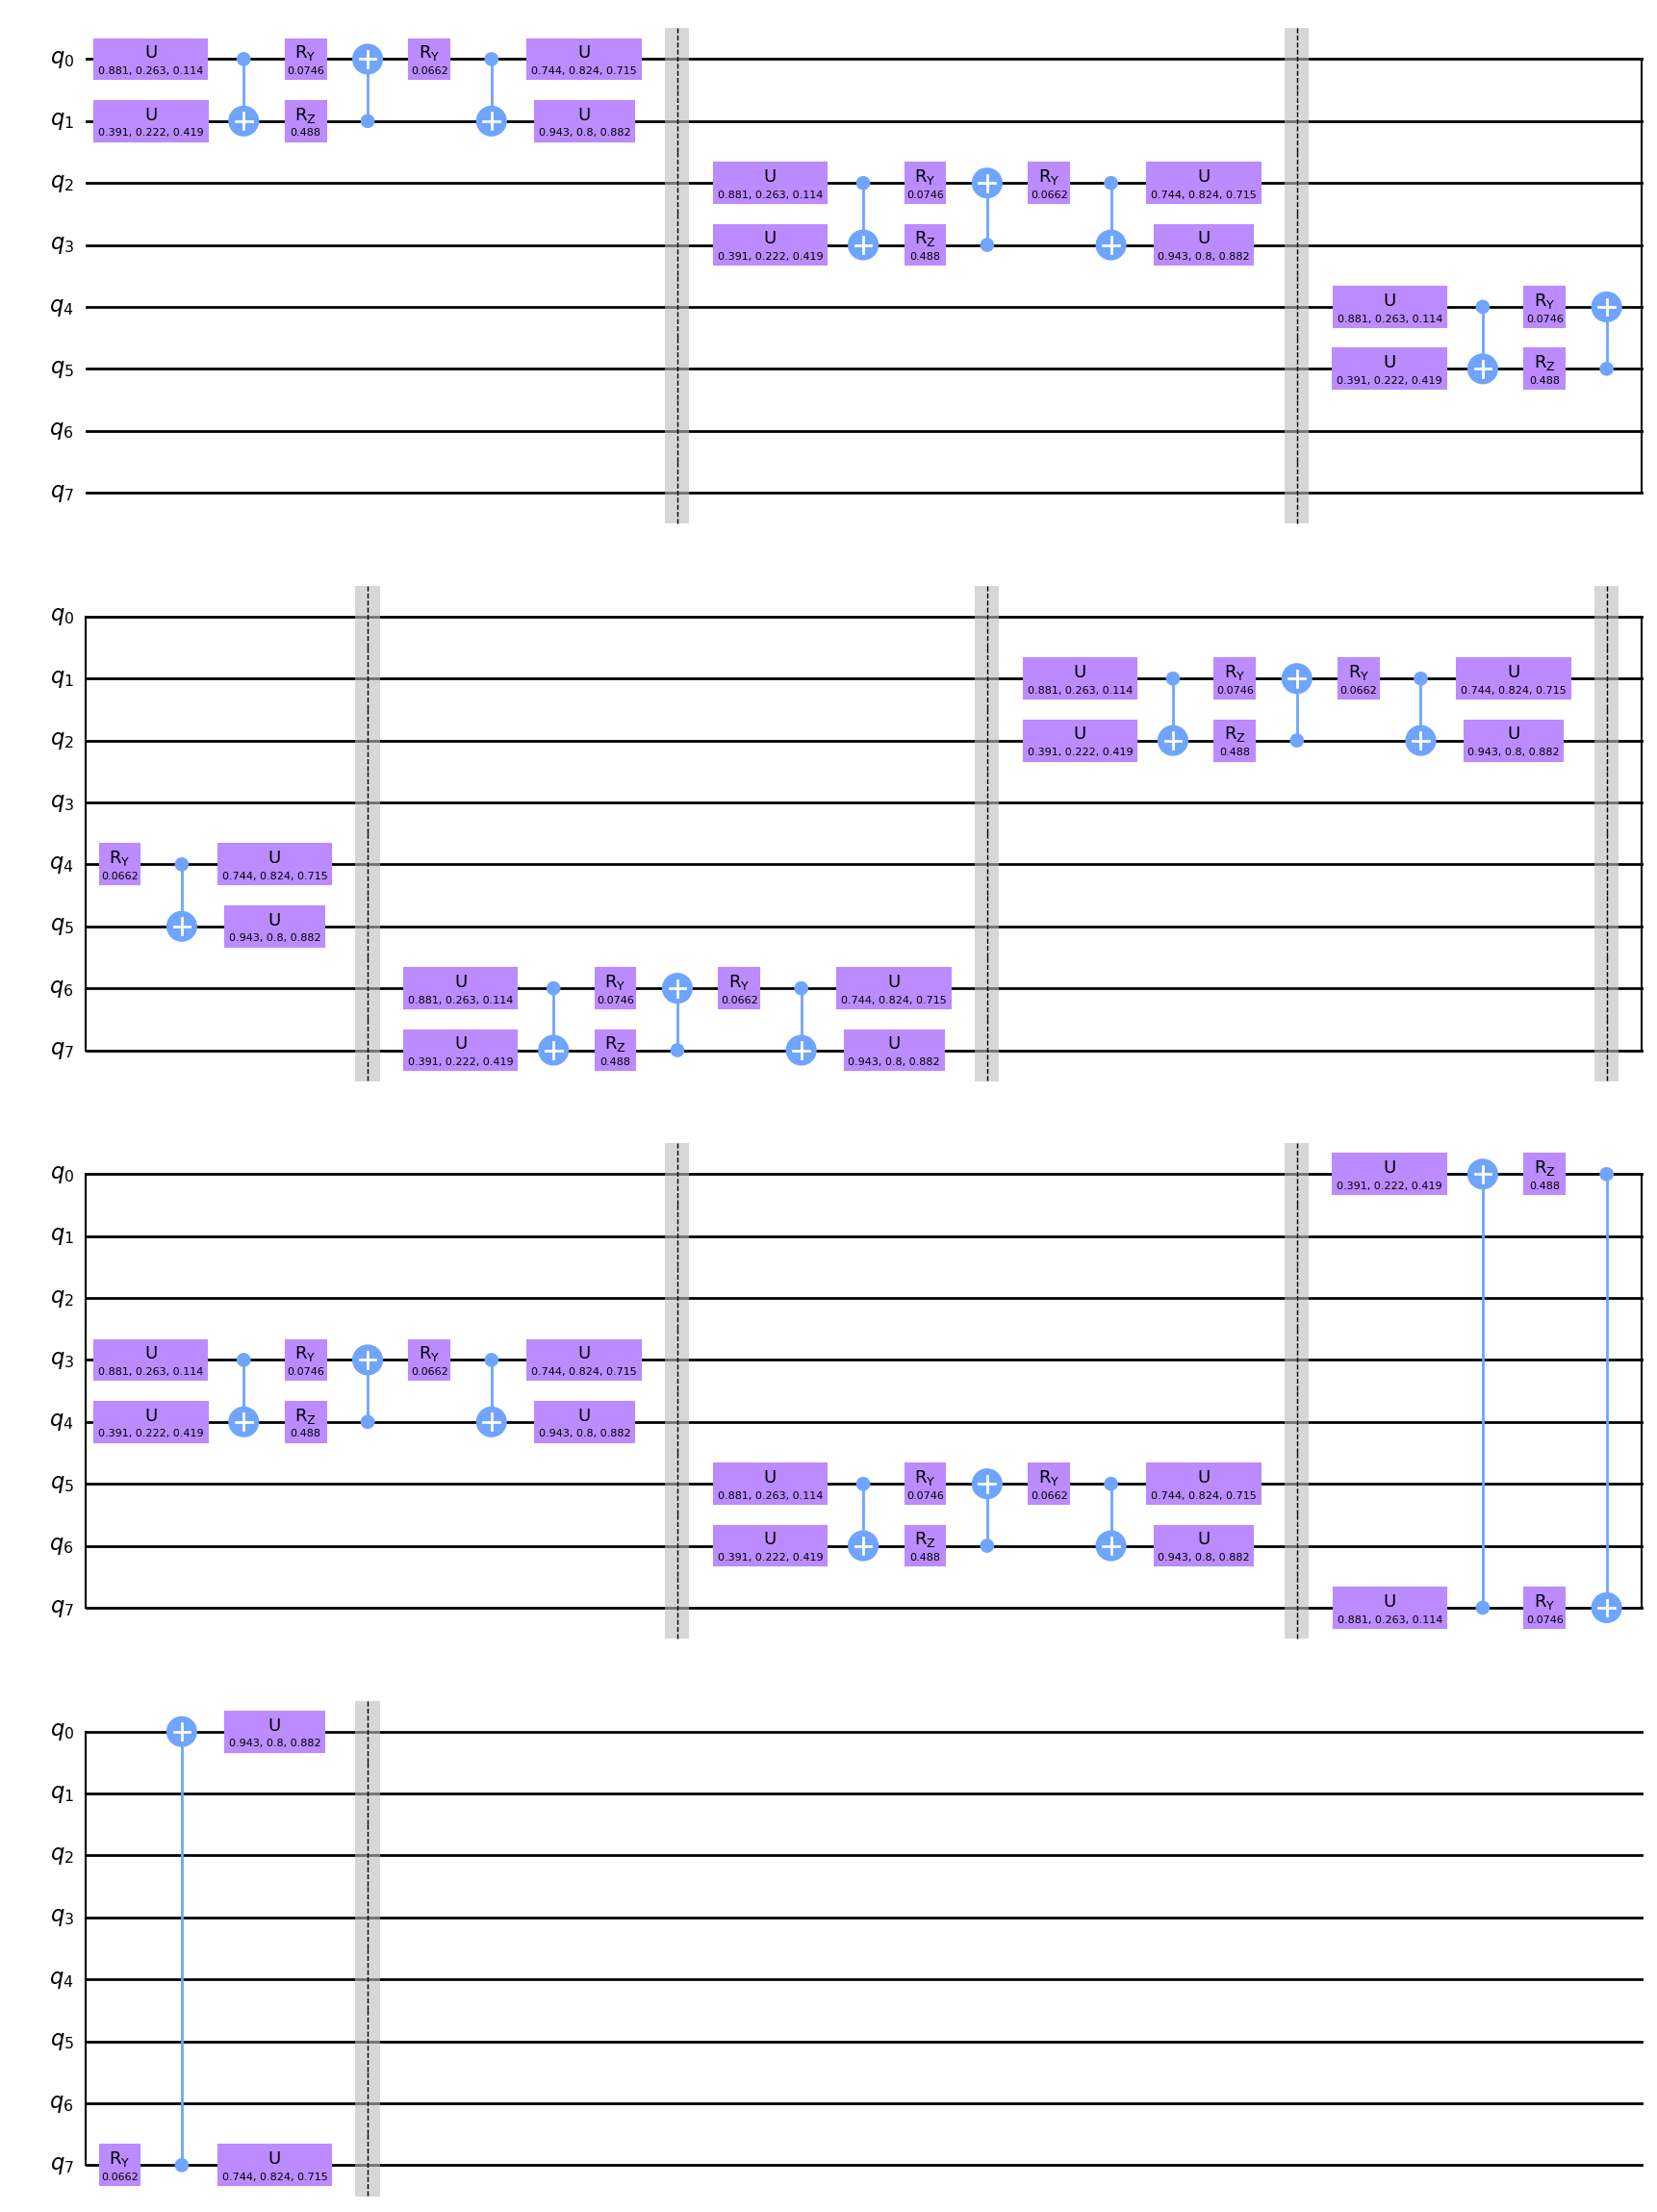

In [20]:
def conv_layer(num_qubits, params):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params), [q1, q2])
        qc.barrier()
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

params = np.random.rand(15)
print(params)
circuit = conv_layer(8, params)
circuit.decompose().draw("mpl")


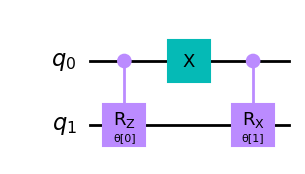

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.crz(params[0], 0, 1)
    target.x(0)
    target.crx(params[1], 0, 1)
    return target

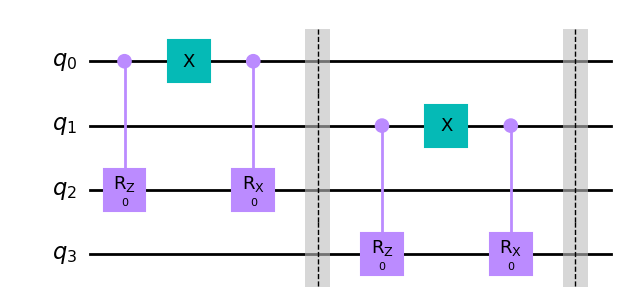

In [22]:
def pool_layer(sources, sinks, params):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
params = [0, 0]
circuit = pool_layer(sources, sinks, params)
circuit.decompose().draw("mpl")

In [6]:
X, y = load_01(256)

print(type(X))
print(type(y))

/Users/wooseophwang/opt/anaconda3/envs/trade/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
def construct_conv_pool(params):
    ansatz = QuantumCircuit(8, name="Ansatz")
    ansatz.compose(conv_layer(8, params[0:15]), list(range(8)), inplace=True)
    ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], params[15:17]), list(range(8)), inplace=True)
    
    ansatz.compose(conv_layer(4, params[17:32]), list(range(4, 8)), inplace=True)
    ansatz.compose(pool_layer([0, 1], [2, 3], params[32:34]), list(range(4, 8)), inplace=True)
    
    ansatz.compose(conv_layer(2, params[34:49]), list(range(6, 8)), inplace=True)
    ansatz.compose(pool_layer([0], [1], params[49:51]), list(range(6, 8)), inplace=True)
    return ansatz

    

In [28]:
def preparation_circuit(X):
    sp_org = QAlchemyInitialize(X, opt_params={'max_fidelity_loss':0.0})
    qc = transpile(sp_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    return qc

In [30]:
def construct_full_circuit(X, params):
    qc = QuantumCircuit(8)
    
    embedding = preparation_circuit(X)
    conv_and_pool = construct_conv_pool(params)
    
    qc.compose(embedding, list(range(8)),inplace=True)
    qc.compose(conv_and_pool, list(range(8)),inplace=True)
    
    return qc
    

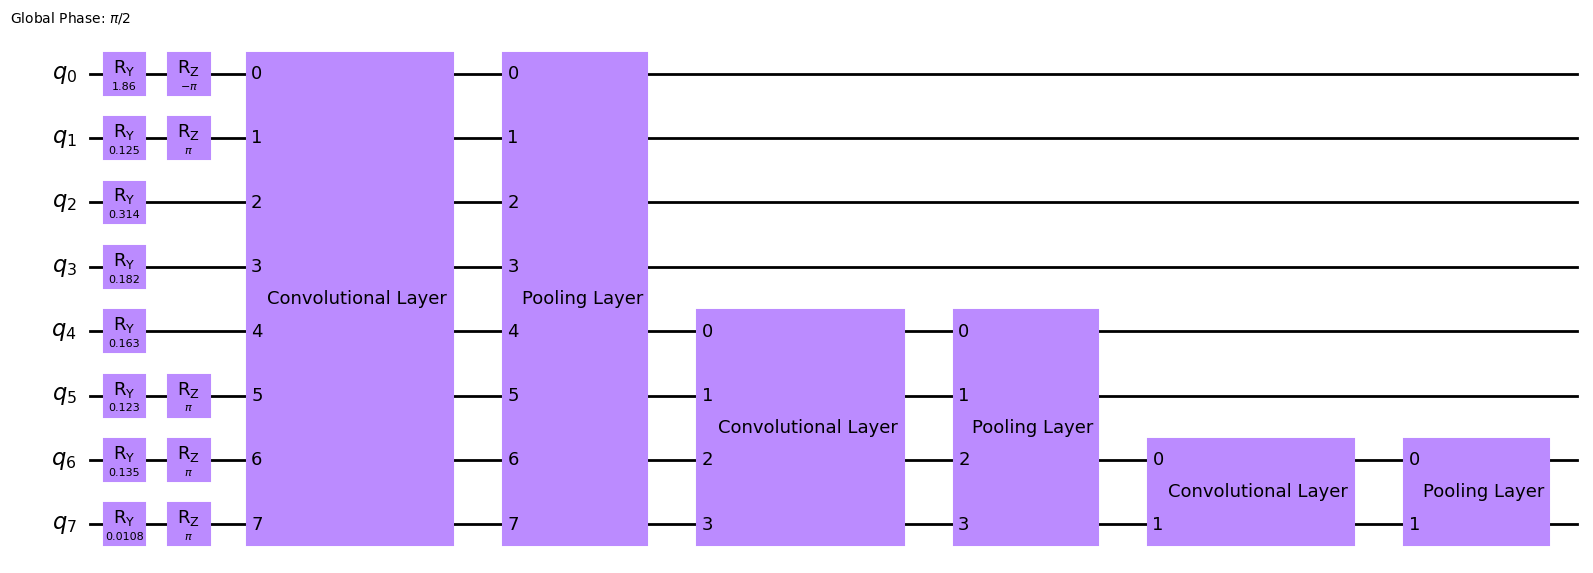

In [31]:
params = np.random.rand(51)
qc = construct_full_circuit(X_train[0], params)
qc.draw("mpl")

In [60]:
def predicted_label(qc):
    full_statevector = Statevector(qc)
    partial_density_matrix = partial_trace(full_statevector, list(range(7)))
    partial_statevector = np.diagonal(partial_density_matrix)
    
    if partial_statevector[0] > partial_statevector[1]:
        label = 0
    else:
        label = 1
        
    return label

## Training QCNN

In [66]:
def cost(params, X, Y):
    predictions = []
    for x in X:
        qc = construct_full_circuit(x, params)
        predictions.append(predicted_label(qc))
        
    loss = log_loss(Y, predictions)
    return loss


In [67]:
def circuit_training(X_train, Y_train, steps, batch_size):

    initial_params = np.random.randn(51)
    
    batch_results = []

    for it in range(steps):
        print(f"starting iteration {it}")
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        result = minimize(
                    lambda params: cost(params, X_batch, Y_batch),
                    initial_params,
                    method='COBYLA'  # You can choose a different optimization method
                )
        updated_params = result.x
        batch_cost = result.fun
        
        batch_results.append({'batch': it, 'params': updated_params, 'cost': batch_cost})

        
        #if it % 10 == 0:
        print("iteration: ", it, " cost: ", batch_cost)
    return batch_results

In [68]:
batch_results = circuit_training(X_train, y_train, 200, 25)

starting iteration 0


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/Users/wooseophwang/opt/anaconda3/envs/trade/lib/python3.11/site-packages/urllib3/connectionpool.py", line 714, in urlopen
    httplib_response = self._make_request(
                       ^^^^^^^^^^^^^^^^^^^
  File "/Users/wooseophwang/opt/anaconda3/envs/trade/lib/python3.11/site-packages/urllib3/connectionpool.py", line 403, in _make_request
    self._validate_conn(conn)
  File "/Users/wooseophwang/opt/anaconda3/envs/trade/lib/python3.11/site-packages/urllib3/connectionpool.py", line 1053, in _validate_conn
    conn.connect()
  File "/Users/wooseophwang/opt/anaconda3/envs/trade/lib/python3.11/site-packages/urllib3/connection.py", line 419, in connect
    self.sock = ssl_wrap_socket(
                ^^^^^^^^^^^^^^^^
  File "/User

: 

: 